In [36]:
import numpy as np
import pandas as pd
from utils import DataManipulation, Measures

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn import model_selection, preprocessing, linear_model, metrics, Linear

plt.style.use("ggplot")
pd.set_option('display.max_columns', 200)

In [37]:
data = pd.read_csv('./data/advertising.csv')

In [38]:
n, m = data.shape
print(f'Rows: {n} \nFeatures: {m}')

Rows: 200 
Features: 5


In [39]:
data.drop("Idx", axis=1, inplace=True)

In [40]:
data.head(10)

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
5,8.7,48.9,75.0,7.2
6,57.5,32.8,23.5,11.8
7,120.2,19.6,11.6,13.2
8,8.6,2.1,1.0,4.8
9,199.8,2.6,21.2,10.6


In [41]:
data.columns

Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')

In [42]:
data.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [43]:
data.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


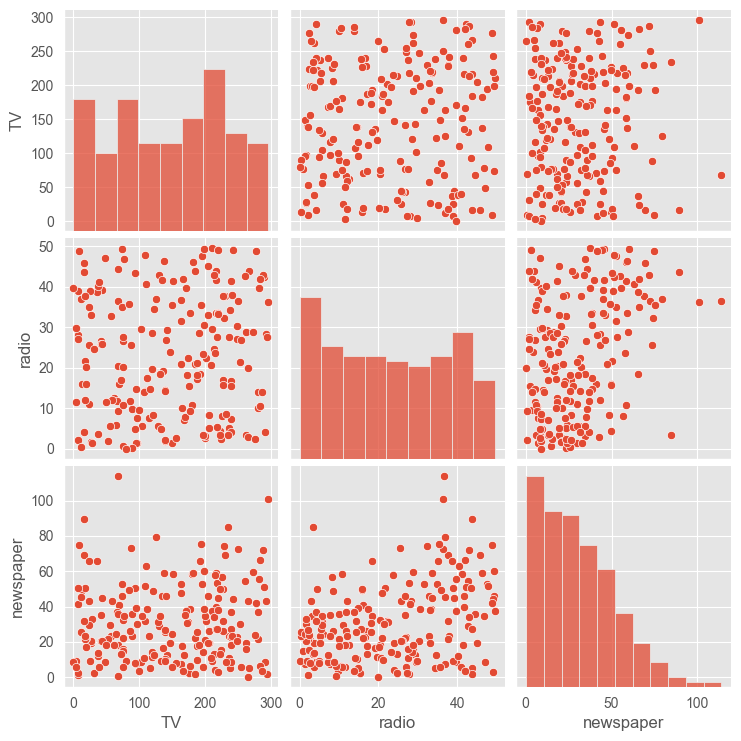

In [45]:
indp_vars = ["TV", "radio", "newspaper"]
ax = sns.pairplot(data=data, vars=indp_vars)
plt.rcParams["figure.figsize"] = (5,4)
plt.show()

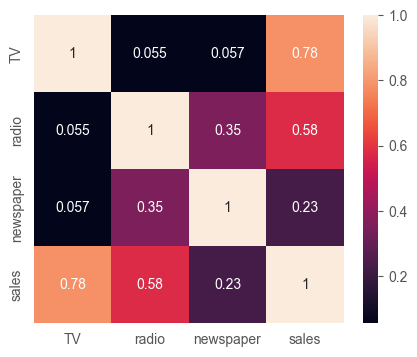

In [46]:
sns.heatmap(data.corr(), annot=True)
plt.rcParams["figure.figsize"] = (9,6)
plt.show()

In [47]:
target = 'sales'

data_norm = DataManipulation.z_score_normalization(data)

X = data_norm.drop([target], axis=1)
y = data_norm[target]

In [48]:
k, TEST_SIZE, SEED = 5, 0.3, 42

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

folds = DataManipulation.kfold(X_train, y_train, k)

In [49]:
def predict(W, X, b) -> pd.Series:
    return np.dot(X, W.T) + b

In [50]:
def calc_mse(y_actual, y_hat, n):
    return (1 / 2*n) * np.sum(((y_actual - y_hat)**2))

In [77]:
def calc_gradient(W, X, b, y, n):
    y_hat = predict(W, X, b)
    error = y_hat.flatten() - y
    
    dy_dW = (1 / n) * np.dot(X.T, error)
    dy_db = (1 / n) * np.sum(error)
    
    return dy_db, dy_dW

In [78]:
def gd(W, X, b, y, n, iterations, alpha):
    
    error_hist = []
    
    for i in range(iterations):
        dy_db, dy_dW = calc_gradient(W, X, b, y, n)
        
        b -= alpha * dy_db
        W -= alpha * dy_dW
        
        error_hist.append(calc_mse(y, predict(W, X, b).flatten(), X.shape[0]))
    
    return W, b, error_hist

In [96]:
initial_W, initial_b, iterations = np.zeros((1,X_train.shape[1])), 0, 50

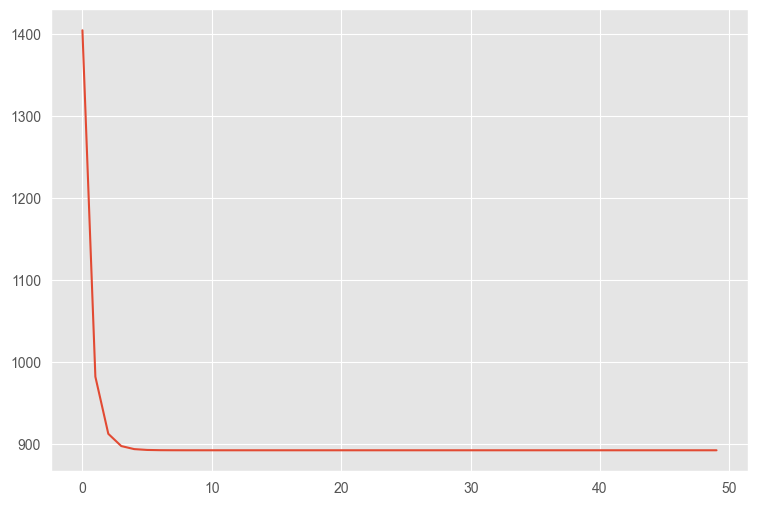

In [97]:
curr_W, curr_b, curr_error_hist = gd(initial_W, X_train, initial_b, y_train, n, iterations, 0.6)
plt.plot([x for x in range(iterations)], curr_error_hist)
plt.show()

In [104]:
initial_W, initial_b, iterations = np.zeros((1,X_train.shape[1])), 0, 100000
alphas = [0.1, 0.3, 0.01, 0.03, 0.001, 0.003, 0.0001, 0.0003, 0.00001, 0.00003]

min_val_error, best_alpha, best_W, best_b, best_err_hist = float('inf'), None, None, None, None

for alpha in alphas:
    for train_data, val_data in folds:
        X_train_curr = np.delete(train_data, -1, axis=1)
        y_train_curr = train_data[:, -1]
    
        X_val_curr = val_data.drop([target], axis=1)
        y_val_curr = val_data[target]    
        
        
        n, m = X_train_curr.shape
        
        curr_W, curr_b, curr_error_hist = gd(initial_W, X_train_curr, initial_b, y_train_curr, n, iterations, alpha)
        
        val_error = calc_mse(y_val_curr, predict(curr_W, X_val_curr, curr_b).flatten(), X_val_curr.shape[0])
        # plt.plot([x for x in range(iterations)], curr_error_hist)
        # plt.show()
        if val_error < min_val_error and not np.any(np.isnan(curr_W)):
            min_val_error = val_error 
            best_alpha = alpha
            best_W = curr_W
            best_b = curr_b
            best_err_hist = curr_error_hist
            
print(best_alpha, min_val_error)
print(best_W)
print(best_b)
    

1e-05 27.163962060310933
[[0.70678321 0.56703583 0.0290684 ]]
0.002791384765562989


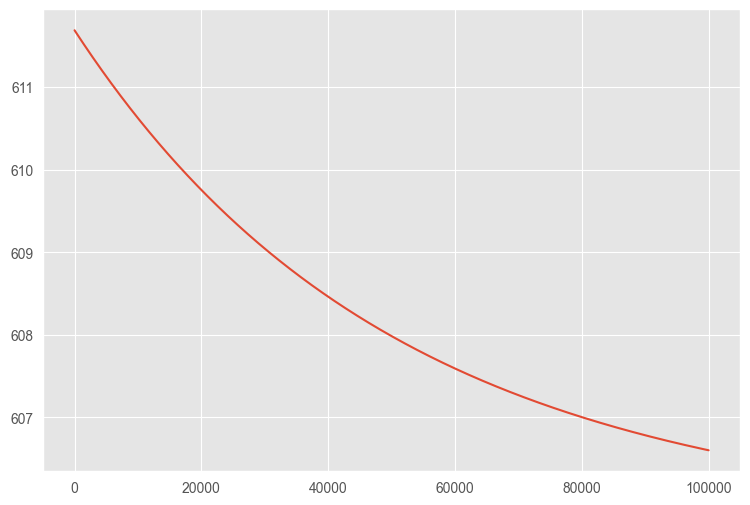

In [105]:
plt.plot([x for x in range(iterations)], best_err_hist)
plt.show()

In [106]:
sgdr = linear_model.SGDRegressor(max_iter=100000)
sgdr.fit(X_train, y_train)

SGDRegressor(max_iter=100000)

In [113]:
mse_sgdr = metrics.mean_squared_error(y_test, sgdr.predict(X_test))
r_2_sgdr = metrics.r2_score(y_test, sgdr.predict(X_test))

mse_custom = metrics.mean_squared_error(y_test, predict(best_W, X_test, best_b))
r_2_custom = metrics.r2_score(y_test, predict(best_W, X_test, best_b))

print("Sklearn SDG regression Benchmark")
print(f"MSE: {mse_sgdr*100:.2f}%")
print(f"R_2: {r_2_sgdr*100:.2f}%")
print("-----------------")
print("Custom SDG regression Benchmark")
print(f"MSE: {mse_custom*100:.2f}%")
print(f"R_2: {r_2_custom*100:.2f}%")

Sklearn SDG regression Benchmark
MSE: 14.34%
R_2: 85.71%
-----------------
Custom SDG regression Benchmark
MSE: 14.29%
R_2: 85.75%


In [110]:
mse_custom = metrics.mean_squared_error(y_test, predict(best_W, X_test, best_b))
r_2_custom = metrics.r2_score(y_test, predict(best_W, X_test, best_b))


print(f"MSE: {mse_custom*100:.2f}%")
print(f"R_2: {r_2_custom*100:.2f}%")

MSE: 14.29%
R_2: 85.75%
